In [1]:
!pip install transformers accelerate
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
from transformers import AutoImageProcessor, TFSwinForImageClassification
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Layer
import tensorflow as tf
import numpy as np### math computations
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import layers, Sequential

from keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-2,
    "N_EPOCHS": 30,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 5,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["0","1","2","3","4"],
}

In [6]:
dataset_loc = '/content/drive/MyDrive/Messidor-2+EyePac_Balanced-Clahe'


In [7]:
from datasets import load_dataset
dataset = load_dataset(dataset_loc)
train_dataset = dataset["train"]

# Split the "train" split into train and validation
from datasets import Dataset
train_dataset = train_dataset.train_test_split(test_size=0.2)

# Assign the splits back to the dataset
dataset["train"] = train_dataset["train"]
dataset["validation"] = train_dataset["test"]

Resolving data files:   0%|          | 0/1810 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1448
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 362
    })
})

In [9]:
from transformers import AutoFeatureExtractor
model_name = "microsoft/swin-tiny-patch4-window7-224"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [10]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x.convert('RGB') for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

prepared_dataset = {}
for split in ["train", "validation"]:
    prepared_dataset[split] = dataset[split].with_transform(transform)

In [11]:
import torch

def collate_fn(batch):
  #data collator
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

def compute_metrics(p):
    predictions = np.argmax(p.predictions, axis=1)
    references = p.label_ids
    accuracy = accuracy_score(references, predictions)
    precision = precision_score(references, predictions, average="macro", zero_division="warn")
    recall = recall_score(references, predictions, average="macro", zero_division="warn")
    # return {"accuracy": accuracy, "precision": precision, "recall": recall}

    conf_matrix = confusion_matrix(references, predictions)
    labels = dataset['train'].features['label']
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

    return {"accuracy": accuracy, "precision": precision, "recall": recall},fig.get_figure()

In [18]:
from transformers import SwinForImageClassification, Trainer, TrainingArguments

labels = dataset['train'].features['label'].names

# initialzing the model
model = SwinForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes = True,
)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
ex = dataset['train'][400]
print(ex)

# seeing the image
image = ex['image']
image.show()

# getting all the labels
labels = dataset['train'].features['label']
print(labels)

# getting label of our example
print(labels.int2str(ex['label']))

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=300x300 at 0x7A9583EA3760>, 'label': 3}
ClassLabel(names=['0', '1', '2', '3', '4'], id=None)
3


In [45]:
from transformers import Trainer, TrainingArguments

batch_size = 16
# Defining training arguments (set push_to_hub to false if you don't want to upload it to HuggingFace's model hub)
training_args = TrainingArguments(
    f"/content/drive/MyDrive/Swin_e20",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=20,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

# Instantiate the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["validation"],
    tokenizer=feature_extractor,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [46]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall
0,0.061100,1.102885,0.732044,0.741941,0.734953
1,0.109600,1.276855,0.704420,0.751760,0.704559
2,0.181800,1.164013,0.696133,0.693506,0.697654
4,0.107900,1.364257,0.660221,0.674514,0.664636
5,0.049600,1.519083,0.715470,0.734035,0.714407
6,0.041400,1.403579,0.732044,0.738664,0.733375
8,0.061200,1.423727,0.734807,0.741220,0.735370
9,0.035900,1.594977,0.712707,0.724458,0.713497
10,0.035200,1.749084,0.707182,0.721051,0.711684
12,0.042800,1.710772,0.726519,0.729206,0.728182


***** train metrics *****
  epoch                    =     19.3407
  total_flos               = 648409963GF
  train_loss               =      0.0549
  train_runtime            =  0:11:41.56
  train_samples_per_second =      41.279
  train_steps_per_second   =       0.627


In [47]:
metrics = trainer.evaluate(prepared_dataset["validation"])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =    19.3407
  eval_accuracy           =     0.7348
  eval_loss               =     1.4237
  eval_precision          =     0.7412
  eval_recall             =     0.7354
  eval_runtime            = 0:00:04.67
  eval_samples_per_second =     77.478
  eval_steps_per_second   =      4.923


In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(predictions, references, labels):
    conf_matrix = confusion_matrix(references, predictions)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", ax=ax, xticklabels=labels, yticklabels=labels)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")
    plt.show()

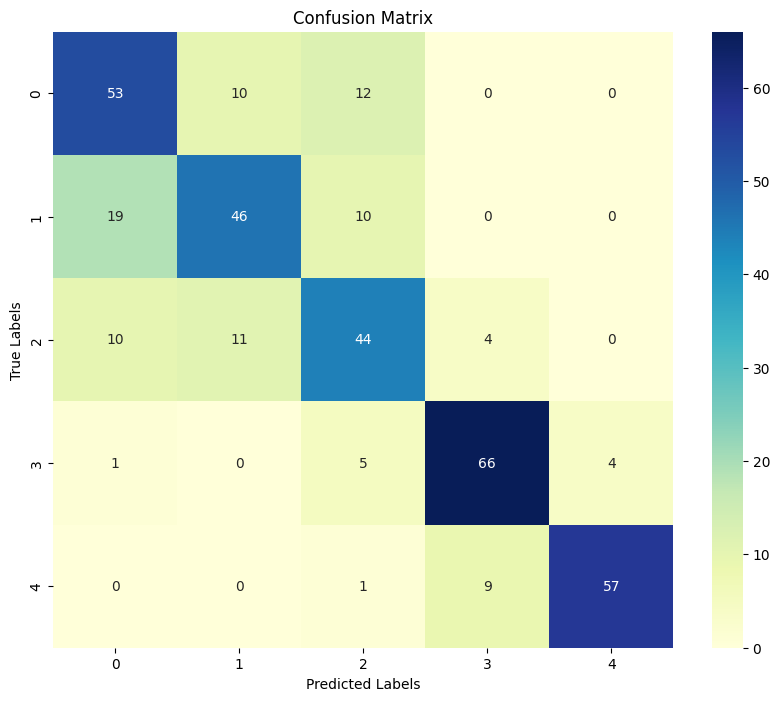

In [49]:
predictions = trainer.predict(prepared_dataset["validation"])

# Plot the confusion matrix
plot_confusion_matrix(predictions.predictions.argmax(axis=1), predictions.label_ids, prepared_dataset['validation'].features['label'].names)